# Name: Soh Jian Min
# Admin Number: P2238856
# Class: EL/EP0302/FT/01
# Title: Market Trends and Insights for Housing Agents in Singapore: Analyzing Popular Flat Types, Sales, and Economic Influences
---
## Story Line
As a data analyst, I aim to assist a housing agent company named "houseNow" in Singapore in understanding market trends and identifying the most popular types of flats and sales. This is crucial for advising clients and making informed decisions.

## Questions
1. What types of sales are most popular in the private residential property market?
2. Which flat types are most popular in the HDB resale market?
3. Does GDP and GNI affect the price index of HDB and Private housing?
4. Does GDP and GNI affect the Applications/Transactions of HDB and Private housing?
5. What types of flats should housing agents focus on to maximize their sales?
6. How do the prices of private and HDB resale properties compare across different quarters?

## Data Source
1. https://beta.data.gov.sg/datasets/d_7c69c943d5f0d89d6a9a773d2b51f337/view (Private Residential Property Transactions in the Whole of Singapore, Quarterly)
2. https://beta.data.gov.sg/datasets/d_02aa4bb51bc674f3a2d0b9bb6911d934/view (Number of Resale Applications Registered by Flat Type)
3. https://beta.data.gov.sg/datasets/d_14f63e595975691e7c24a27ae4c07c79/view (Housing And Development Board Resale Price Index (1Q2009 = 100), Quarterly)
4. https://beta.data.gov.sg/datasets/d_97f8a2e995022d311c6c68cfda6d034c/view (Private Residential Property Price Index (Base Quarter 2009-Q1 = 100), Quarterly)
5. https://beta.data.gov.sg/datasets/d_dce7d88c668273bb8c1291027e63325a/view (Per Capita GNI And Per Capita GDP At Current Prices, Annual)

## Load data from CSV files

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_check_data(file_path, var_name):
    # Load the dataset
    df = pd.read_csv(file_path)
    print("Successfully loaded dataset " + file_path)
    # To check if the data needs to  be transposed
    if df.shape[0] < df.shape[1]:
        print(var_name + ' data needs to be transposed')
    
    return df

# Load datasets
private_sales = load_and_check_data('PrivateResidentialPropertyTransactionsintheWholeofSingaporeQuarterly.csv', 'private_sales')
hdb_resale = load_and_check_data('NumberofResaleApplicationsRegisteredbyFlatType.csv', 'hdb_resale')
hdb_resale_price_index = load_and_check_data('HousingAndDevelopmentBoardResalePriceIndex1Q2009100Quarterly.csv', 'hdb_resale_price_index')
private_residential_price_index = load_and_check_data('PrivateResidentialPropertyPriceIndexBaseQuarter2009Q1100Quarterly.csv', 'private_residential_price_index')
gdp_data = load_and_check_data('PerCapitaGNIAndPerCapitaGDPAtCurrentPricesAnnual.csv', 'gdp_data')



Successfully loaded dataset PrivateResidentialPropertyTransactionsintheWholeofSingaporeQuarterly.csv
Successfully loaded dataset NumberofResaleApplicationsRegisteredbyFlatType.csv
Successfully loaded dataset HousingAndDevelopmentBoardResalePriceIndex1Q2009100Quarterly.csv
Successfully loaded dataset PrivateResidentialPropertyPriceIndexBaseQuarter2009Q1100Quarterly.csv
Successfully loaded dataset PerCapitaGNIAndPerCapitaGDPAtCurrentPricesAnnual.csv
gdp_data data needs to be transposed


# Transpose Data & Text-Based Analysis

In [34]:
# Transpose gdp data (horizontal to vertical)
gdp_data = gdp_data.transpose()
gdp_data.columns = gdp_data.iloc[0]  # Set the first row as the header
gdp_data = gdp_data.drop(gdp_data.index[0])  # Drop the first row
gdp_data = gdp_data.reset_index()
gdp_data.columns.name = None # Remove the column name
gdp_data.rename(columns={'index': 'year'}, inplace=True)

# Do a Text-Based Analysis on the datasets
def text_based_analysis(df, var_name, col_for_descriptive_stats=[]):
    # Make sure that 'na' is replaced with pd.NA (correct format for missing values)
    df.replace('na', pd.NA, inplace=True)
    print("Text-Based Analysis for " + var_name)
    print()

    # Shape of the dataset
    print('This is the shape of the dataset:')
    print(df.shape)
    print()
    
    # Index of the dataset
    print('This is the index of the dataset:')
    print(df.index)
    print()
    
    # Columns of the dataset
    print('These are the columns of the dataset:')
    print(df.columns)
    print()
    
    # Non-NA values of each column in the dataset
    print('The total number of non-NA values in the dataset is:')
    print(df.count())
    print()

    # NA values of each column in the dataset
    print("The total number of NA values in the dataset is:")
    print(df.isnull().sum())
    print("\n")
    
    # Summary of the dataset
    print("A summary of this dataset is shown below:")
    print(df.info())

    # Descriptive statistics summary of the dataset based on the col_for_descriptive_stats specified
    print("A descriptive statistics summary of this dataset is shown below:")
    for col in col_for_descriptive_stats:
        if col in df.columns:
            print(f"A descriptive statistical summary of this dataset is shown below for: {col}")
            if df[col].dtype in ['float64', 'int64']:
                print(df[col].describe())
            else:
                print(df[col].astype('float64').describe())
            print()
        else:
            print(f"Column '{col}' not found in the dataset.")
            print()
            print()

    print("=====================================================================")
    print()

text_based_analysis(private_sales, 'private_sales', ["units"])
text_based_analysis(hdb_resale, 'hdb_resale', ["no_of_resale_applications"])
text_based_analysis(hdb_resale_price_index, 'hdb_resale_price_index', ["index"])
text_based_analysis(private_residential_price_index, 'private_residential_price_index', ["index"])
text_based_analysis(gdp_data, 'gdp_data', ["Per Capita GNI", "Per Capita GDP", "Per Capita GNI (US Dollar)", "Per Capita GDP (US Dollar)"])


Text-Based Analysis for private_sales

This is the shape of the dataset:
(392, 4)

This is the index of the dataset:
RangeIndex(start=0, stop=392, step=1)

These are the columns of the dataset:
Index(['quarter', 'type_of_sale', 'sale_status', 'units'], dtype='object')

The total number of non-NA values in the dataset is:
quarter         392
type_of_sale    392
sale_status     196
units           392
dtype: int64

The total number of NA values in the dataset is:
quarter           0
type_of_sale      0
sale_status     196
units             0
dtype: int64


A summary of this dataset is shown below:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   quarter       392 non-null    object
 1   type_of_sale  392 non-null    object
 2   sale_status   196 non-null    object
 3   units         392 non-null    int64 
dtypes: int64(1), object(3)
memory usage:

# Cleaning, filtering and transforming Datasets

In [36]:
# Cleaning the data

# Replace NaN values with 'Total Applications' in the 'sale_status' column
private_sales['sale_status'] = private_sales['sale_status'].fillna('Applied')


# Transforming the data
# private_sales
# Pivot the DataFrame
pivot_df = private_sales.pivot_table(index='quarter', columns=['type_of_sale', 'sale_status'], values='units', aggfunc='sum')
# Flatten the MultiIndex columns
pivot_df.columns = ['private_' + '_'.join(col).lower().strip() if isinstance(col, tuple) else col.lower() for col in pivot_df.columns]
# Reset the index to turn the 'quarter' index back into a column
pivot_df = pivot_df.reset_index()
# Expected columns
expected_columns = ['quarter', 'private_new sale_completed', 'private_new sale_uncompleted', 'private_resale_applied', 'private_sub sale_applied']
# Reindex to ensure all expected columns are present, filling missing columns with 0
pivot_df = pivot_df.reindex(columns=expected_columns, fill_value=0)
# Assign the pivoted DataFrame back to the original DataFrame
private_sales=pivot_df

# hdb_resale
# Pivot the DataFrame
pivot_df = hdb_resale.pivot_table(index='quarter', columns='flat_type', values='no_of_resale_applications', aggfunc='sum')
# Flatten the MultiIndex columns and convert to lowercase
pivot_df.columns = ['hdb_' + col.replace(' ', '_').replace("-", "_").lower() for col in pivot_df.columns]
# Reset the index to turn the 'quarter' index back into a column
pivot_df = pivot_df.reset_index()
# Expected columns
expected_columns = ['quarter', 'hdb_1_room', 'hdb_2_room', 'hdb_3_room', 'hdb_4_room', 'hdb_5_room', 'hdb_executive']
# Reindex to ensure all expected columns are present, filling missing columns with 0
pivot_df = pivot_df.reindex(columns=expected_columns, fill_value=0)
# Rename pivot_df back to hdb_resale
hdb_resale = pivot_df

# private_residential_price_index
# Group by 'quarter' and calculate the mean of 'index'
private_residential_price_index= private_residential_price_index.groupby('quarter')['index'].mean().reset_index()
# Round the index values to 1 decimal place
private_residential_price_index['index'] = private_residential_price_index['index'].round(1)

# Filtering and Joining the Datasets
# Merge datasets on quarter (inner join to keep only rows with matching quarters)
merged_data = private_sales.merge(hdb_resale, on='quarter', how='inner')
merged_data = merged_data.merge(hdb_resale_price_index, on='quarter', how='inner')
merged_data = merged_data.merge(private_residential_price_index, on='quarter', how='inner', suffixes=('_hdb', '_private'))

# Extract year from quarter for GDP data merging
merged_data['year'] = merged_data['quarter'].str[:4].astype(int)
# Ensure the year column is of the same type in both DataFrames
gdp_data['year'] = gdp_data['year'].astype(str)
merged_data['year'] = merged_data['year'].astype(str)
# Merge GDP data based on year(left join to keep all rows in merged_data)
merged_data = merged_data.merge(gdp_data, on='year', how='left')
# Drop the 'year' column as it's no longer needed
merged_data = merged_data.drop(columns=['year'])

# Convert columns to appropriate numeric types
columns_to_numeric = [
    'private_new sale_completed', 'private_new sale_uncompleted', 'private_resale_applied', 'private_sub sale_applied',
    'hdb_1_room', 'hdb_2_room', 'hdb_3_room', 'hdb_4_room', 'hdb_5_room', 'hdb_executive',
    'index_hdb', 'index_private', 'Per Capita GNI', 'Per Capita GDP',
    'Per Capita GNI (US Dollar)', 'Per Capita GDP (US Dollar)'
]

for col in columns_to_numeric:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Drop rows with any NaN values
merged_data.dropna(inplace=True)


# Question 1: What types of sales are most popular in the private residential property market?

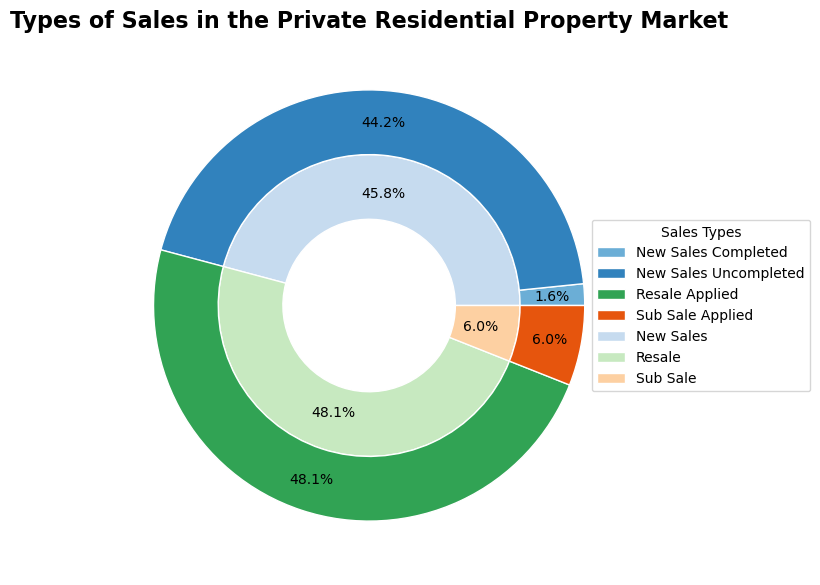

In [37]:
# Sum the sales data
new_sales_completed = merged_data['private_new sale_completed'].sum()
new_sales_uncompleted = merged_data['private_new sale_uncompleted'].sum()
resale_applied = merged_data['private_resale_applied'].sum()
sub_sale_applied = merged_data['private_sub sale_applied'].sum()

# Data for the outer layer
outer_sizes = [new_sales_completed, new_sales_uncompleted, resale_applied, sub_sale_applied]
outer_labels = ['New Sales Completed', 'New Sales Uncompleted', 'Resale Applied', 'Sub Sale Applied']

# Data for the inner layer
inner_sizes = [new_sales_completed + new_sales_uncompleted, resale_applied, sub_sale_applied]
inner_labels = ['New Sales', 'Resale', 'Sub Sale']

# inner ring colour with light shades
inner_colors = ['#c6dbef', '#c7e9c0', '#fdd0a2']  # light shades

# Plotting the donut chart
fig, ax = plt.subplots(figsize=(7, 7))
size = 0.3

# Inner ring
wedges1, texts1, autotexts1 = ax.pie(
    inner_sizes, labels=None, radius=1-size, 
    wedgeprops=dict(width=size, edgecolor='w'), 
    autopct='%1.1f%%', pctdistance=0.75, colors=inner_colors
)

# Outer ring with darker shades
outer_colors = ['#6baed6', '#3182bd', '#31a354', '#e6550d']

wedges2, texts2, autotexts2 = ax.pie(
    outer_sizes, labels=None, radius=1, 
    wedgeprops=dict(width=size, edgecolor='w'), 
    autopct='%1.1f%%', pctdistance=0.85, colors=outer_colors
)

# Set aspect ratio to be equal
ax.set(aspect="equal")

# Title
plt.title('Types of Sales in the Private Residential Property Market', fontweight='bold', fontsize=16)

# Legend
legend_labels = ['New Sales Completed', 'New Sales Uncompleted', 'Resale Applied', 'Sub Sale Applied', 'New Sales', 'Resale', 'Sub Sale']
ax.legend(wedges2 + wedges1, legend_labels, title="Sales Types", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))

# Display the plot
plt.show()

## Analysis of Types of Sales in the Private Residential Property Market

**1. Dominance of New Sales:**
   - **New Sales (both completed and uncompleted)** make up a big part of the market, with 45.8% of total sales.
   - Most of these are **New Sales Uncompleted** (44.2%), while only a small part are **New Sales Completed** (1.6%).

**2. Resale Market:**
   - **Resale Applied** is the biggest part of the market, at 48.1%. This shows that many buyers prefer resale properties over new ones.
   - The high percentage of resale properties shows a strong secondary market for private residential properties.

**3. Sub Sale Market:**
   - **Sub Sale Applied** is the smallest segment, making up 6.0% of total sales. This means sub-sales (where properties are sold before the initial buyer completes the transaction) are less common compared to new sales and resale applied.

## Market Implications
- **Supply and Demand for New Sales:**
   - The large number of new sales, especially uncompleted ones, shows a high demand for new developments. However, the low number of completed new sales might indicate delays in project completions or buyers preferring to buy off-plan properties.

- **Resale Market Robustness:**
   - The high number of resale applied properties highlights strong demand for existing homes. This could be due to things like better location, established neighborhoods, or lower prices.

- **Lower Sub Sale Activity:**
   - The small percentage of sub sales suggests fewer investors are quickly flipping properties. This might indicate market stability, with more end-users buying homes for personal use rather than for investment.

## Recommendations

**1. Marketing Strategy:**
   - **New Sales Marketing**:
     - Promote the benefits of buying off-plan properties, like customization options and potential price increases.
     - Highlight projects with good completion records to reassure buyers worried about delays.
   - **Resale Market Marketing**:
     - Emphasize the benefits of buying resale properties, such as moving in right away, established communities, and possibly lower prices compared to new developments.
     - Showcase well-maintained resale properties in good locations to attract buyers.

**2. Buyer Recommendations:**
   - **For Immediate Occupancy**:
     - Recommend resale properties to buyers who need to move in quickly, as these homes are already available.
   - **For Investment and Future Planning**:
     - Advise buyers interested in new developments to consider uncompleted new sales, focusing on long-term benefits and potential for price increases.
     - Encourage buyers to research developers and project timelines to avoid delays.

**3. Continuous Market Monitoring:**
   - Watch trends in the sub sale market to spot any changes in investor behavior.
   - Monitor the completion rates of new developments to adjust marketing strategies as needed.

By focusing marketing efforts on the most popular types of sales and tailoring recommendations based on buyers' needs and budgets, housing agents at "houseNow" can better meet client demands and optimize their sales strategies.

# Question 2: Which flat types are most popular in the HDB resale market?

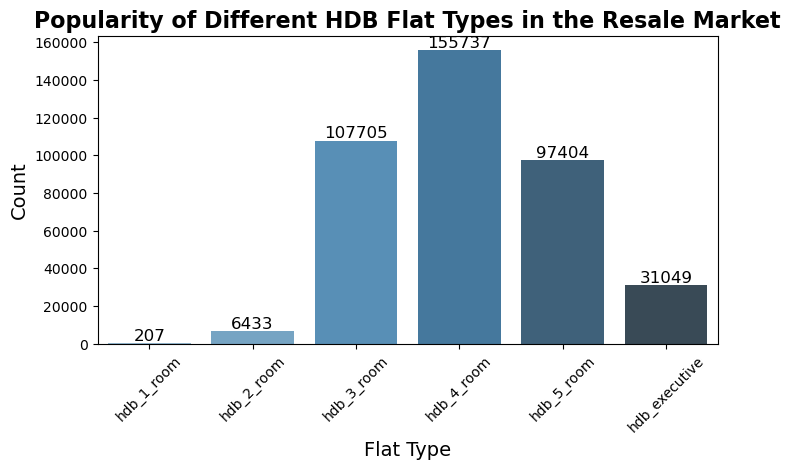

In [38]:
# Sum the counts for each flat type column
flat_type_sums = merged_data[['hdb_1_room', 'hdb_2_room', 'hdb_3_room', 'hdb_4_room', 'hdb_5_room', 'hdb_executive']].sum()

# Create a DataFrame for plotting
flat_type_counts = flat_type_sums.reset_index()
flat_type_counts.columns = ['Flat Type', 'Count']

# Plot the bar chart using Seaborn
plt.figure(figsize=(8, 4))
bar_plot = sns.barplot(x='Flat Type', y='Count', hue='Flat Type', data=flat_type_counts, palette='Blues_d', dodge=False, legend=False)
plt.title('Popularity of Different HDB Flat Types in the Resale Market', fontweight='bold', fontsize=16)
plt.xlabel('Flat Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)

# Add the sum on top of each bar
for index, row in flat_type_counts.iterrows():
    bar_plot.text(row.name, row.Count, round(row.Count, 2), color='black', ha="center", va="bottom", fontsize=12)

plt.show()

## Analysis of the Popularity of Different HDB Flat Types in the Resale Market

1. **General Observations**:
   - **HDB 4-room Flats**: The most popular type, with 155,737 units.
   - **HDB 3-room Flats**: The second most popular, with 107,705 units.
   - **HDB 5-room Flats**: The third most popular, with 97,404 units.
   - Other flat types such as 1-room (207 units), 2-room (6,433 units), and executive flats (31,049 units) are less popular.

2. **Recommendations**:
   - **Focus on Popular Flat Types**: Since 3-room, 4-room, and 5-room flats are the most popular, housing agents should prioritize these types in their listings and marketing strategies.
   - **Tailor Recommendations Based on Needs and Budget**:
     - **HDB 4-room Flats**: Great for families looking for a balance of space and affordability. Recommend these to buyers seeking a widely available and popular option.
     - **HDB 3-room Flats**: Suitable for smaller families or couples who need a moderate amount of space. Recommend these to buyers with a lower budget who still want a popular flat type.
     - **HDB 5-room Flats**: Best for larger families or those who need more space. Recommend these to buyers with a higher budget and need for more room.
   - **Budget Considerations**: Make sure buyers are aware of their budget constraints and guide them towards the flat type that fits their financial situation. For instance:
     - **Lower Budget**: Recommend 3-room flats.
     - **Moderate Budget**: Recommend 4-room flats.
     - **Higher Budget**: Recommend 5-room flats or executive flats if additional space and amenities are desired.

3. **Strategic Marketing**:
   - **Highlight Popularity**: Emphasize the popularity of 3-room, 4-room, and 5-room flats in marketing materials to attract potential buyers.
   - **Detailed Listings**: Provide detailed information and attractive listings for these popular flat types to capture buyer interest.
   - **Focus on High-Demand Areas**: Identify and market flats in high-demand areas, particularly for the popular 3-room, 4-room, and 5-room types.

### Conclusion:
The analysis shows that 3-room, 4-room, and 5-room HDB flats are the most popular in the resale market. Housing agents should focus their efforts on these flat types, tailoring their recommendations based on buyers' needs and budget. By concentrating on these popular options and strategically marketing them, agents can better meet client demands and increase the likelihood of successful transactions.

# Question 3: Does GDP and GNI affect the price index of HDB and Private housing?

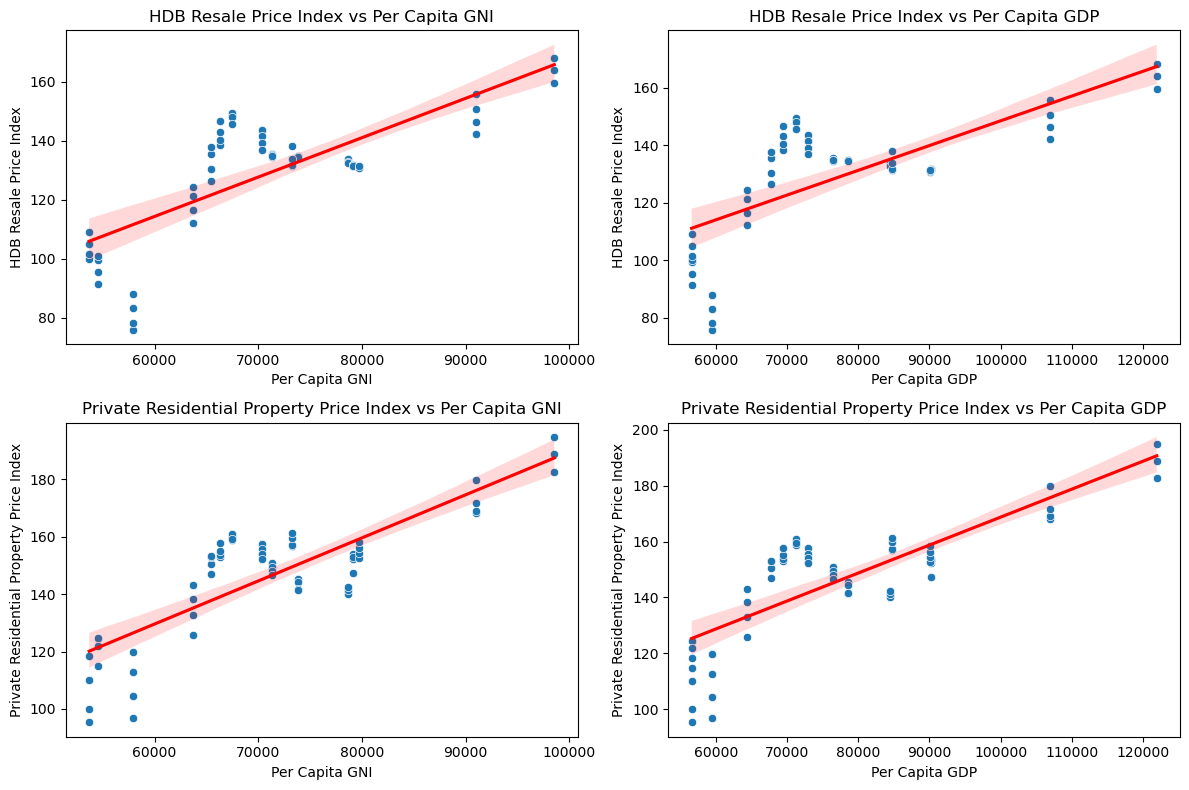

In [39]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Scatter plot for index_hdb vs Per Capita GNI
sns.scatterplot(data=merged_data, x='Per Capita GNI', y='index_hdb', ax=axs[0, 0])
sns.regplot(data=merged_data, x='Per Capita GNI', y='index_hdb', ax=axs[0, 0], scatter=False, line_kws={"color": "red"})
axs[0, 0].set_title('HDB Resale Price Index vs Per Capita GNI')
axs[0, 0].set_xlabel('Per Capita GNI')
axs[0, 0].set_ylabel('HDB Resale Price Index')

# Scatter plot for index_hdb vs Per Capita GDP
sns.scatterplot(data=merged_data, x='Per Capita GDP', y='index_hdb', ax=axs[0, 1])
sns.regplot(data=merged_data, x='Per Capita GDP', y='index_hdb', ax=axs[0, 1], scatter=False, line_kws={"color": "red"})
axs[0, 1].set_title('HDB Resale Price Index vs Per Capita GDP')
axs[0, 1].set_xlabel('Per Capita GDP')
axs[0, 1].set_ylabel('HDB Resale Price Index')

# Scatter plot for index_private vs Per Capita GNI
sns.scatterplot(data=merged_data, x='Per Capita GNI', y='index_private', ax=axs[1, 0])
sns.regplot(data=merged_data, x='Per Capita GNI', y='index_private', ax=axs[1, 0], scatter=False, line_kws={"color": "red"})
axs[1, 0].set_title('Private Residential Property Price Index vs Per Capita GNI')
axs[1, 0].set_xlabel('Per Capita GNI')
axs[1, 0].set_ylabel('Private Residential Property Price Index')

# Scatter plot for index_private vs Per Capita GDP
sns.scatterplot(data=merged_data, x='Per Capita GDP', y='index_private', ax=axs[1, 1])
sns.regplot(data=merged_data, x='Per Capita GDP', y='index_private', ax=axs[1, 1], scatter=False, line_kws={"color": "red"})
axs[1, 1].set_title('Private Residential Property Price Index vs Per Capita GDP')
axs[1, 1].set_xlabel('Per Capita GDP')
axs[1, 1].set_ylabel('Private Residential Property Price Index')

plt.tight_layout()
plt.show()

### Analysis for HDB Resale Price Index vs Per Capita GNI & HDB Resale Price Index vs Per Capita GDP

1. **General Observations**:
   - The price index for both per capita GNI and GDP shows a positive trend, meaning as GNI and GDP increase, the HDB resale price index also increases.
   - This indicates that higher economic indicators are associated with higher HDB prices.

2. **Recommendations**:
   - **Timing Purchases**: Recommend buyers consider purchasing HDB properties when GDP and GNI are lower, as prices might be lower during these times.
   - **Market Monitoring**: Regularly monitor GDP and GNI trends to identify the best times for buyers to make purchases and adjust marketing strategies accordingly.
   - **Predictive Analysis**: Use GDP and GNI forecasts to advise clients on optimal times to buy, improving the chances of successful transactions.

## Analysis for Private Residential Property Price Index vs Per Capita GNI & Private Residential Property Price Index vs Per Capita GDP

1. **General Observations**:
   - The price index for private residential properties also shows a positive correlation with both per capita GNI and GDP. As GNI and GDP increase, the private residential property price index rises.
   - This suggests that higher economic indicators are linked to higher prices for private residential properties as well.

2. **Recommendations**:
   - **Timing Purchases**: Advise buyers to consider purchasing private properties when GDP and GNI are lower, potentially securing better prices.
   - **Market Monitoring**: Regularly monitor GDP and GNI to recommend the best times to buy and adjust marketing efforts accordingly.
   - **Predictive Analysis**: Use GDP and GNI predictions to guide property buying decisions.
   - **Income Level Consideration**: Since private property prices are generally higher, make sure to match property choices to buyers' income levels to prevent overspending.

### Conclusion:

The analysis shows that both HDB and private residential property price indices increase with higher GDP and GNI. Housing agents should:

- **Advise Clients on Timing**: Encourage clients to make purchases when GDP and GNI are lower to benefit from potentially lower prices.
- **Monitor Economic Trends**: Keep a close watch on economic indicators to identify the best buying periods and adjust marketing strategies accordingly.
- **Provide Strategic Insights**: Use predictive analysis to offer clients timely advice, helping them make informed and successful investment decisions.
- **Consider Budget and Income Levels**: For private properties, ensure that buyers are aware of the higher price indexes and recommend options that fit their budget and income levels to avoid the housing recommendation is being unaffordable for the buyers.

# Question 4: Does GDP and GNI affect the Applications/Transactions of HDB and Private housing?

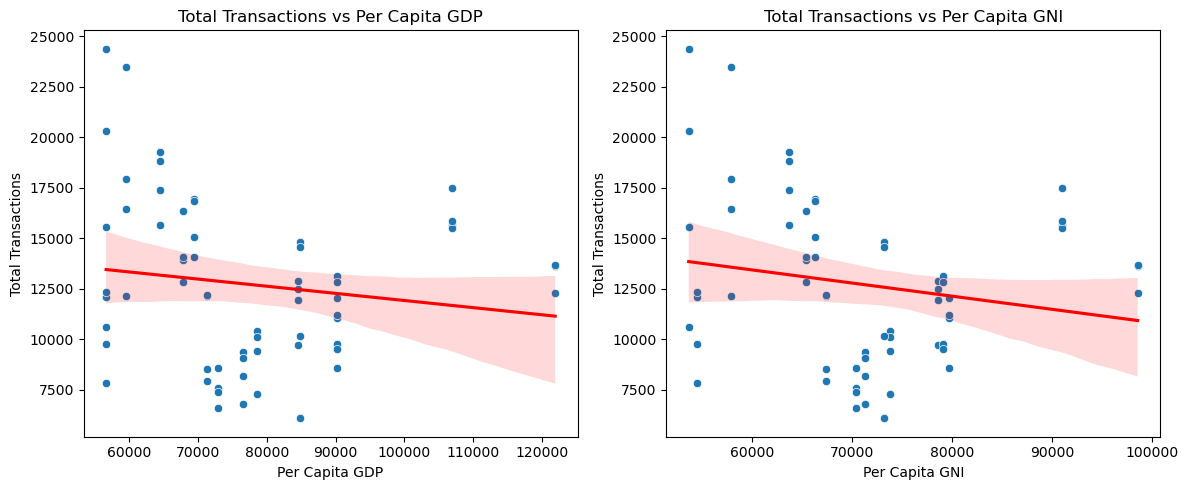

In [40]:
# Create a copy of the DataFrame to avoid modifying the original data
plot_data = merged_data.copy()

# Aggregate the transactions/applications data
plot_data['total_transactions'] = plot_data[
    ['private_new sale_completed', 'private_new sale_uncompleted', 'private_resale_applied', 'private_sub sale_applied',
     'hdb_1_room', 'hdb_2_room', 'hdb_3_room', 'hdb_4_room', 'hdb_5_room', 'hdb_executive']
].sum(axis=1)

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for Per Capita GDP vs total transactions
sns.scatterplot(data=plot_data, x='Per Capita GDP', y='total_transactions', ax=axes[0])
sns.regplot(data=plot_data, x='Per Capita GDP', y='total_transactions', ax=axes[0], scatter=False, line_kws={"color": "red"})
axes[0].set_title('Total Transactions vs Per Capita GDP')
axes[0].set_xlabel('Per Capita GDP')
axes[0].set_ylabel('Total Transactions')

# Scatter plot for Per Capita GNI vs total transactions
sns.scatterplot(data=plot_data, x='Per Capita GNI', y='total_transactions', ax=axes[1])
sns.regplot(data=plot_data, x='Per Capita GNI', y='total_transactions', ax=axes[1], scatter=False, line_kws={"color": "red"})
axes[1].set_title('Total Transactions vs Per Capita GNI')
axes[1].set_xlabel('Per Capita GNI')
axes[1].set_ylabel('Total Transactions')

plt.tight_layout()
plt.show()

## Analysis of the Relationship Between GDP, GNI, and Housing Transactions

1. **General Observations**:
   - Scatter plots show how total transactions relate to per capita GDP (left) and GNI (right).
   - Both graphs show a negative trend: as GDP and GNI rise, transactions tend to fall.

2. **Per Capita GDP vs. Total Transactions**:
   - The plot on the left shows that as per capita GDP increases, the total transactions generally decrease.
   - This negative correlation suggests that higher GDP might be associated with fewer housing transactions.
   - The line of best fit (red line) clearly indicates this downward trend, with the shaded area representing the confidence interval of the regression line.

3. **Per Capita GNI vs. Total Transactions**:
   - The plot on the right shows a similar trend where increasing per capita GNI is associated with a decrease in total transactions.
   - The negative slope of the red line suggests a consistent decrease in transactions as GNI rises.
   - The confidence interval again supports this negative correlation.

#### Recommendations:

1. **Buyer Strategy**:
   - **Timing Purchases**: Recommend buyers to consider purchasing properties when GDP and GNI are lower. These periods tend to have more transactions happening, which could indicate better buying conditions.
   - **Market Monitoring**: Keep an eye on economic indicators such as GDP and GNI. Consistent monitoring and understanding of these trends can help them make informed decisions about when to enter the market.

2. **Marketing Strategy**:
   - **Focus During Low GDP/GNI Periods**: Agents should intensify their marketing efforts during periods when GDP and GNI are lower. Increased transactions during these times suggest higher market activity, making it a good opportunity for both selling and buying.
   - **Highlighting Economic Conditions**: Use economic trends as a selling point. Educate potential buyers about the benefits of purchasing during times of lower GDP and GNI to capitalize on higher market activity.

3. **Consistent Monitoring**:
   - **Predictive Analysis**: Regularly analyze GDP and GNI predictions and trends in GDP and GNI to predict market behavior. This proactive approach allows agents to adjust their strategies in anticipation of market changes.
   - **Client Advisory**: Provide clients with updated economic insights to help them understand the best times to buy or sell properties based on current and predicted economic conditions.

### Conclusion:

The analysis indicates that higher GDP and GNI are associated with fewer housing transactions. Housing agents should focus their marketing strategies during periods of lower GDP and GNI to take advantage of higher transaction volumes. By advising clients on the best times to buy based on these economic indicators, agents can help them make more informed decisions and optimize their investments. Consistent monitoring of GDP and GNI predictions is crucial for staying ahead in the market and offering valuable insights to clients.

# Question 5: Should housing agents focus more on HDB or Private housing flats?

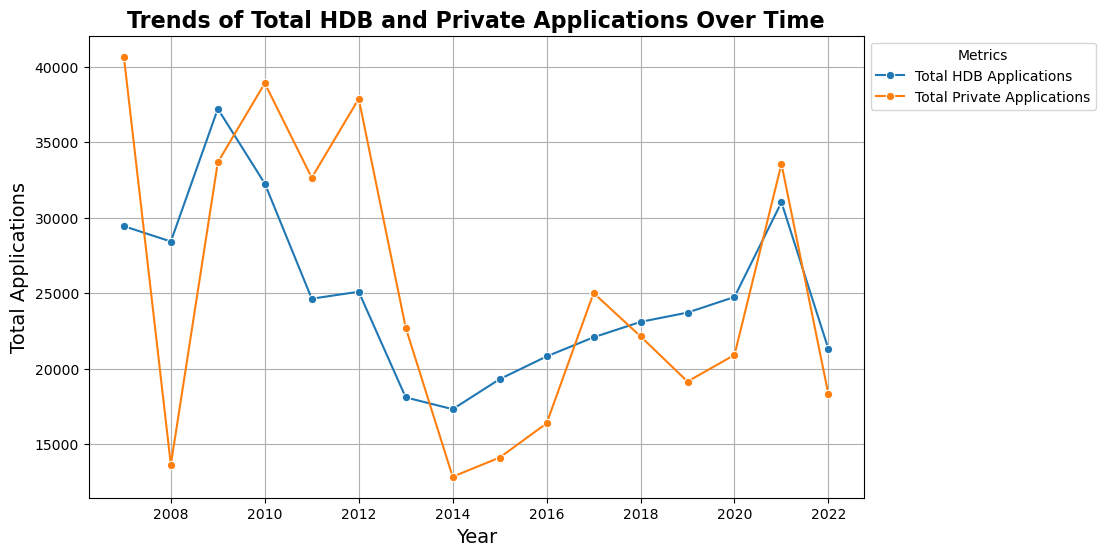

In [41]:
# Create a copy of the DataFrame for processing
processed_data = merged_data.copy()

# Sum total HDB applications
processed_data['total_hdb_applications'] = processed_data[
    ['hdb_1_room', 'hdb_2_room', 'hdb_3_room', 'hdb_4_room', 'hdb_5_room', 'hdb_executive']
].sum(axis=1)

# Sum total private applications
processed_data['total_private_applications'] = processed_data[
    ['private_new sale_completed','private_new sale_uncompleted', 'private_resale_applied', 'private_sub sale_applied']
].sum(axis=1)

# Extract the year from the quarter column
processed_data['year'] = processed_data['quarter'].str[:4].astype(int)

# Group by year and calculate annual sums
annual_data = processed_data.groupby('year').sum().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))

# Plot each series with a different color
sns.lineplot(data=annual_data, x='year', y='total_hdb_applications', label='Total HDB Applications', marker='o')
sns.lineplot(data=annual_data, x='year', y='total_private_applications', label='Total Private Applications', marker='o')

plt.title('Trends of Total HDB and Private Applications Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Applications', fontsize=14)
plt.legend(title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## Analysis of Trends of Total HDB and Private Applications Over Time
1. **Early Trends (2007-2010)**:
   - In 2007, there were a lot more private housing applications than HDB applications.
   - Private applications dropped sharply in 2008 but bounced back in 2009-2010.
   - HDB applications were more stable during this period.

2. **Middle Trends (2011-2014)**:
   - From 2011 to 2013, both HDB and private applications fluctuated, with private applications generally being higher.
   - In 2013-2014, private applications saw a significant decline, while HDB applications also decreased but at a slower rate.

3. **Recent Trends (2015-2022)**:
   - Between 2015 and 2018, both HDB and private applications were relatively low, with private applications picking up a bit in 2017.
   - From 2019 to 2022, both HDB and private applications increased, with peaks in 2020 and 2022.
   - Overall, both HDB and private applications have been recovering in recent years, with HDB applications showing a more consistent upward trend.

#### Recommendations:
- **Market Analysis**: Continuously monitor market trends and economic indicators like GDP to make informed decisions.
- **Diversified Strategy**: Maintain a balanced portfolio by focusing on both HDB and private flats to achieve stability and potential high returns.

#### Conclusion:
- **Focus on Both**: Both HDB and private applications have shown fluctuations and recoveries. Housing agents should focus on both, adjusting their strategy based on market conditions and economic factors.
- **HDB Applications**: HDB applications tend to be more stable and predictable. Agents preferring stability might focus more on HDB flats.
- **Private Applications**: Private applications are more unpredictable but can hit higher peaks, offering the chance for higher returns during good market times.

# Question 6: How do the prices of private and HDB resale properties compare across different quarters?

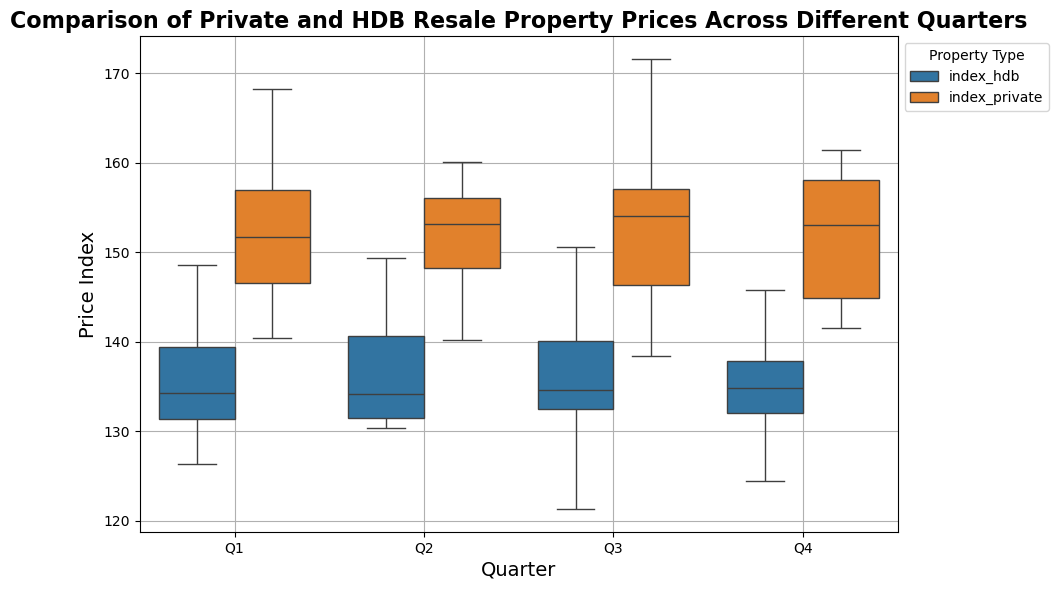

In [42]:
# Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)
    return df.loc[filter]

# Extract the quarter part (Q1, Q2, Q3, Q4) from the quarter column
merged_data['quarter_only'] = merged_data['quarter'].str[-2:]

# Remove outliers for both index types
merged_data_no_outliers_hdb = remove_outliers(merged_data, 'index_hdb')
merged_data_no_outliers = remove_outliers(merged_data_no_outliers_hdb, 'index_private')

# Prepare data for plotting
data_for_plotting = merged_data_no_outliers.melt(id_vars='quarter_only', 
                                                 value_vars=['index_hdb', 'index_private'],
                                                 var_name='Index Type', 
                                                 value_name='Price Index')

# Plot the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='quarter_only', y='Price Index', hue='Index Type', data=data_for_plotting, showfliers=False)

plt.title('Comparison of Private and HDB Resale Property Prices Across Different Quarters', fontsize=16, fontweight='bold')
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Price Index', fontsize=14)
plt.legend(title='Property Type', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis of Comparison of Private and HDB Resale Property Prices Across Different Quarters

1. **General Observations:**
   - **Private Property Prices**: Generally higher than HDB resale property prices across all quarters. This suggests that private properties are more suitable for higher-income individuals who can afford them.
   - **HDB Resale Property Prices**: Lower than private property prices, making them more suitable for middle-income individuals or those looking for more affordable housing options.

2. **Price Stability and Variability:**
   - **Private Properties**:
     - **Q1**: Shows higher variability with the lowest median price for private properties around 150.
     - **Q2**: Prices are relatively stable, with the median price slightly higher than in Q1.
     - **Q3**: The highest variability for private properties and a median price around 150.
     - **Q4**: Prices have high IQR variability but the lowest variability outside the IQR, with the second-lowest median price for private properties around 150.
   - **HDB Resale Properties**:
     - **Q1**: Shows moderate variability with a relatively lower median price.
     - **Q2**: Prices have the highest IQR variability but the lowest variability outside the IQR, with a relatively lower median price.
     - **Q3**: Shows more variability outside the IQR compared to Q2, with the second-highest median price.
     - **Q4**: Prices are the most stable in this quarter with the least IQR variability, moderate variability outside the IQR, and a median price around 130-135.

3. **Higher Prices:**
   - **Private Properties**: Consistently higher compared to HDB Resale Properties across all quarters, with the highest median prices observed in Q4.
   - **HDB Resale Properties**: Consistently lower than private properties, with the highest median prices observed in Q4.

### Recommendations:

1. **Targeting Different Income Groups**:
   - **High-Income Clients**: Recommend private properties, especially during quarters with lower variability (Q2 and Q4) to minimize risk and ensure price stability.
   - **Middle-Income Clients**: Suggest HDB resale properties, focusing on quarters where prices are more stable (Q4) to offer more predictable investment.

2. **Advising on Market Timing**:
   - **Private Properties**: Advise clients to invest in private properties in Q2 and Q4 when price variability is lower. Be cautious with Q1 and Q3 due to higher price fluctuations.
   - **HDB Resale Properties**: Recommend buying in Q4 for the most stable prices. Avoid Q2 if clients don’t like risk due to higher IQR variability.

3. **Strategy for Different Economic Conditions**:
   - **During Economic Growth**: Focus on private properties as clients might be more willing to invest in premium housing with higher returns.
   - **During Economic Uncertainty**: Suggest HDB resale properties due to their affordability and more stable price trends.

4. **Long-Term Investment**:
   - Encourage clients to consider long-term investments in HDB resale properties for steady growth and predictability.
   - For high-return potential, suggest diversifying with selective investments in private properties during stable quarters.

### Conclusion:
By looking at the trends and variability of private and HDB resale property prices across different quarters, we can give good advice to housing agents at "houseNow."

- **For high-income buyers**, private properties are a better choice, especially in Q2 and Q4 when price sre more stable.
- **For middle-income buyers**, HDB resale properties are more suitable, particularly in Q4 for stable prices.

Agents should use this analysis to help their clients based on their budget and income level, aligning recommendations with current market conditions and economic trends. This will help clients make smart investment decisions, ensuring both stability and potential growth.

# Final Conclusion

### Conclusion Summary
1. **Market Segmentation and Trends**:
   - **Dominance of New and Resale Sales**: The private residential market shows a strong preference for new sales, but there is a large percentage that shows the transaction is uncompleted, and a we should also have a secondary market for resale properties.
   - **Popular HDB Flat Types**: HDB 4-room, 3-room, and 5-room flats are the most popular in the resale market.
   - **Economic Influence**: Both HDB and private property prices tend to increase with higher GDP and GNI, indicating a positive correlation between economic growth and property prices.
   - **Transactions vs. Economic Indicators**: Higher GDP and GNI are associated with fewer housing transactions, suggesting that economic growth might reduce market activity.
   - **Quarterly Price Variability**: Private property prices are generally higher and more variable compared to HDB resale prices, which are more stable, especially in Q4.

### Final Conclusion Points
- **Economic Impact**: Both GDP and GNI significantly influence property prices and transaction volumes. Higher economic indicators lead to higher property prices but fewer transactions.
- **Market Preferences**: There is a clear preference for new sales in the private market and specific flat types (4-room, 3-room, and 5-room) in the HDB market.
- **Price Stability**: HDB resale prices are steady and less risky, perfect for cautious buyers. Private property prices are higher and more unpredictable, better for high-income clients looking for big returns.


# Final Recommendations

1. **Target Market Segmentation**:
   - **High-Income Clients**:
     - Focus on private properties, emphasizing relatively stable quarters (Q2 and Q4) to minimize risk.
   - **Middle-Income Clients**:
     - Emphasize HDB resale properties, particularly 4-room, 3-room, and 5-room flats, and promote Q4 for stability as it relatively more stable than other quarter.

2. **Timing and Market Conditions**:
   - **Advise on Timing**:
     - Recommend private property purchases in Q2 and Q4 fir stability.
     - Suggest HDB purchases in Q4 for stability and lower risk.
   - **Market Monitoring**:
     - Keep a close watch on GDP and GNI to find the best buying times and adjust marketing efforts as needed.

3. **Focus on Popular Flat Types**:
   - **HDB Market**: Prioritize 4-room, 3-room, and 5-room flats in listings and marketing due to their popularity.

4. **Client Education and Advisory**:
   - **Economic Insights**:
     - Educate clients on the impact of economic indicators on property prices.
     - Use economic trends to guide clients on the best times to buy.
   - **Predictive Analysis**:
     - Leverage GDP and GNI predictions to offer strategic advice, enhancing clients' investment decisions.

5. **Long-Term Investment Strategy**:
   - Encourage clients to consider long-term investments in HDB resale properties for steady growth.
   - Suggest diversifying with selective private properties during stable quarters for higher returns.

By following these recommendations, housing agents at "houseNow" can better meet client demands, optimize sales strategies, and enhance overall market performance.